# Control Theory Tutorial  (DRAFT, NOT APPROVED YET)
## The Cart-Pole System - Python for System Analysis

## 1. Introduction
The goal of this tutorial is to teach the usage of the programming language Python as a
tool for developing and simulating control systems. The following topics are covered:

- Derivation of the equations of motion through Lagrangian mechanics and scientific computing
- Linearization of the resulting nonlinear system equations to obtain a linear system in state space form
- Investigation of the control theoretic properties of the system (equilibria, observability, etc.)

Please refer to the [Python List-Dictionary-Tuple tutorial](http://cs231n.github.io/python-numpy-tutorial/#python-containers) and the [NumPy Array tutorial](http://cs231n.github.io/python-numpy-tutorial/#numpy)
if you are not familiar with the handling of containers and arrays in Python. If you are
completely new to Python consult the very basic introduction on [tutorialspoint](https://www.tutorialspoint.com/python/index.htm). If you don't have any experience with Jupyter Notebook to get started it is recommended to watch the following tutorial:

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('HW29067qVWk')

# 2. The Cart-Pole System
The cart-pole system, as shown in the figure is a common control theory benchmark system, and has different attributes, that make it particular interesting for teaching control theoretic principles and methods. 

The pole is attached to a cart at its end. By applying a force $F$ to the cart through a moment $M$, the cart can be moved in the $x$-direction. The objective is to control the cart, such that the pole, starting in the upright position, doesn't fall over. Another objective is the swing-up manover, where the pole starts from the downright position and has to be brought in the upright position and kept there. The second objective involves nonlinear control theory and is much harder to accomplish than the first.

![Cart-Pole System](img/cart-pole.png)

## 2.1 Derivation of the equations of motion
To derive the equations of motion, Lagrangian mechanics are used. At first the position vectors $\mathbf{p}_i$ of all $i$ rigid bodies' center of mass have to be defined (in this case $i=0,1$). Then the velocities $\dot{\mathbf{p}}_i$ are derived by differentiation. After that the kinetic energy $T$ and potential energy $V$ are described to form the Lagrangian $L$. In the last step the equations of motions are derived by Lagrange's equations of the second kind.

At first the necessary Python libraries are imported.

In [2]:
import numpy as np
import sympy as sp
from sympy import sin, cos, pi, Function
from sympy.interactive import printing
printing.init_printing()

Then symbolic expressions for all system parameters, time and force are defined.

In [3]:
t = sp.Symbol('t') # time
params = sp.symbols('m0, m1, J1, l1, a1, g, d0, d1') # system parameters
m0, m1, J1, l1, a1, g, d0, d1 = params
params_values = [(m0, 3.34), (m1, 0.3583), (J1, 0.0379999),
                 (l1, 0.5), (a1, 0.43), (g, 9.81), (d0, 0.1), (d1, 0.006588)]
# force
F = sp.Symbol('F')

The system has 2 degrees of freedom, $x_0$ and $\varphi_1$. The generelized coordinates $q_i$ are therefore:
\begin{align}
&q_0 =  x_0 &q_1 =  \varphi_1
\end{align}
Because these are time dependent, they and there derivative up to order 2 are implemented as functions.

In [4]:
q0_t = Function('q0')(t)   
dq0_t = q0_t.diff(t)
ddq0_t = q0_t.diff(t, 2)
q1_t = Function('q1')(t) 
dq1_t = q1_t.diff(t)
ddq1_t = q1_t.diff(t, 2)

### 2.1.1 Position vectors $\mathbf{p}_i$
The two rigid bodies of the cart-pole system are as the name suggests, the cart and the pole. The position vectors of the center of masses is found by the follwing expressions:
\begin{align}
&\mathbf{p}_0 = \begin{pmatrix} x_0 \\ 0\end{pmatrix} =\begin{pmatrix} q_0 \\ 0\end{pmatrix} & \mathbf{p}_1 = \begin{pmatrix} x_0 - a_1 \sin \varphi_1 \\ a_1 \cos \varphi_1\end{pmatrix} = \begin{pmatrix} q_0 - a_1 \sin q_1 \\ a_1 \cos q_1\end{pmatrix}
\end{align}
The position vectors are functions of the generalized coordinates.

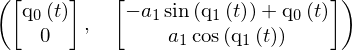

In [5]:
p0 = sp.Matrix([q0_t, 0])
p1 = sp.Matrix([q0_t - a1*sin(q1_t), a1*cos(q1_t)])
p0, p1

### 2.1.2  Velocity vectors $\dot{\mathbf{p}}_i$

The velocity vectors can be obtained by the time derivative.
\begin{align}
&\dot{\mathbf{p}}_0 = \begin{pmatrix} \dot{x}_0 \\ 0\end{pmatrix} =\begin{pmatrix} 
\dot{q}_0 \\ 0\end{pmatrix} 
& \dot{\mathbf{p}}_1 = \begin{pmatrix} \dot{x}_0 - a_1 \dot{\varphi}_1 \cos \varphi_1 
\\ - a_1 \dot{\varphi}_1 \sin \varphi_1\end{pmatrix} 
= \begin{pmatrix} \dot{q}_0 - a_1 \dot{q}_1 \cos q_1 \\ - a_1 \dot{q}_1 \sin q_1\end{pmatrix}
\end{align}

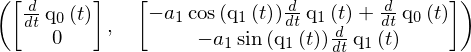

In [6]:
dp0 = p0.diff(t)
dp1 = p1.diff(t)
dp0, dp1

### 2.1.3 Kinetic energy $T$
The total kinetic energy of the system $T$ can be found by the sum of the kinetic energies $T_0$ and $T_1$ of the rigid bodies.

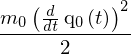

In [7]:
T0 = m0/2*(dp0.T*dp0)[0]
T0

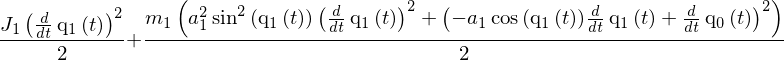

In [8]:
T1 = (m1*(dp1.T*dp1)[0] + J1*dq1_t**2)/2
T1

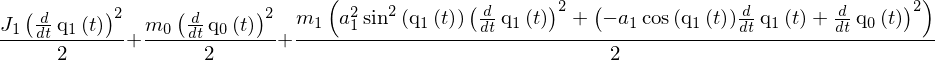

In [9]:
T = T0 + T1
T

### 2.1.3 Potential energy $V$
The total potential energy of the system $V$ can be found by the sum of the kinetic energies $V_0$ and $V_1$ of the rigid bodies. Because $V_0=0$, $V = V_1$.

In [10]:
V = m1*g*p1[1]
V

### 2.1.4 Lagrangian $L$
The Lagrangian is defined as $L = T-V$

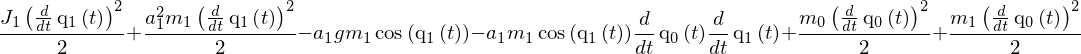

In [11]:
L = T - V
L = L.expand()
L = sp.trigsimp(L)
L

### 2.1.5 Lagrange's equation of the second kind
To obtain the equations of motion, Lagrange's equation of the second kind is used:
\begin{align}
\frac{\mathrm{d}}{\mathrm{d} t}\left(\frac{\partial L}{\partial \dot{q}_i}\right) - \frac{\partial L}{\partial q_i} = Q_i 
\quad i = 0,1\end{align}
with the generalized forces $Q_i$.
Substituting $L = T-V$ leads to:
\begin{align}
\frac{\mathrm{d}}{\mathrm{d} t}\left(\frac{\partial T}{\partial \dot{q}_i} \right) - \frac{\mathrm{d}}{\mathrm{d} t}\left(\frac{\partial V}{\partial \dot{q}_i}\right) - \frac{\partial T}{\partial q_i} + \frac{\partial V}{\partial q_i} = Q_i
\quad i = 0,1\end{align}
For mechanical systems like the cart-pole system $\frac{\mathrm{d}}{\mathrm{d} t}\frac{\partial V}{\partial \dot{q}_i} = 0$. The equation simplifies to:
\begin{align}
\frac{\mathrm{d}}{\mathrm{d} t}\left(\frac{\partial T}{\partial \dot{q}_i}\right) - \frac{\partial T}{\partial q_i} + \left(\frac{\partial V}{\partial q_i}\right) = Q_i
\quad i = 0,1 
\end{align}

The generalized forces can be seperated to a term $B\mathbf{\tau}$ that expresses how the actuator forces $u$ act on the system and a term for the disspitave forces $R$:
\begin{align}
(Q_0,...,Q_n)^\textrm{T} = B\mathbf{\tau} - R
\end{align}

For the cart-pole system one obtains: 
\begin{align}
Q_0 = F - \frac{1}{2}d_0 \dot{q}_0^2 \qquad Q_1 = - \frac{1}{2}d_1 \dot{q}_1^2 
\end{align}

In [12]:
Q0 = F - d0/2*dq0_t**2

In [13]:
Q0 = F - d0*dq0_t

In [14]:
Q1 =  - d1/2*dq1_t**2

In [15]:
Q1 =  - d1*dq1_t

In [16]:
Eq0 = L.diff(dq0_t, t) - L.diff(q0_t) - Q0 # = 0 

In [17]:
Eq1 = L.diff(dq1_t, t) - L.diff(q1_t) - Q1 # = 0

A mechanical system is described by the following equation:
\begin{align}
M(\mathbf{q})\ddot{\mathbf{q}}+C(\mathbf{q},\dot{\mathbf{q}})+K(\mathbf{q},\dot{\mathbf{q}}) - B(\mathbf{q})\mathbf{\tau} = \mathbf{0}
\end{align}

$M$ - mass matrix

$C$ - coriolis vector

$K$ - vector containing potential energy terms and $R$

This eqation is contained in the variable `Eq`.

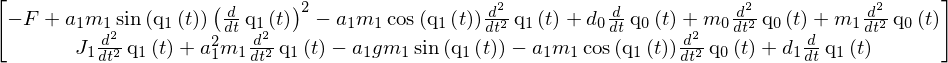

In [18]:
Eq = sp.Matrix([Eq0, Eq1])
Eq

The mass matrix $M$ can be found by applying the differential operator 
$\frac{\mathrm{d}}{\mathrm{d}\mathbf{\ddot{q}}}$ to `Eq`.

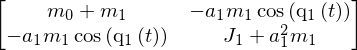

In [19]:
ddq_t = sp.Matrix([ddq0_t, ddq1_t])
M = Eq.jacobian(ddq_t)
M

The mass matrix of mechanical systems is always symmetric and invertible. Therefore an equation for $\ddot{\mathbf{q}}$ always exists.
\begin{align}
\ddot{\mathbf{q}} = M^{-1}(\mathbf{q})\left(-C(\mathbf{q},\dot{\mathbf{q}})-K(\mathbf{q},\dot{\mathbf{q}}) + B(\mathbf{q})\mathbf{\tau} \right)
\end{align}

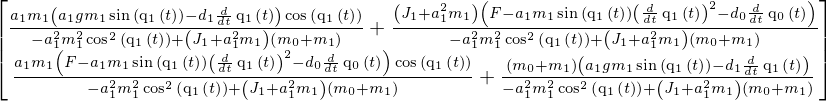

In [20]:
q_zeros = [(ddq0_t, 0), (ddq1_t, 0)]
ddq = M.inv() * -Eq.subs(q_zeros)
ddq

## 2.2 State Space Model
An input-affine, nonlinear system is given by the following equation:
\begin{align}
\dot{\mathbf{x}}=\mathbf{f}(\mathbf{x})+\mathbf{g}(\mathbf{x})\mathbf{u} \qquad \mathbf{x} \textrm{ - state vector}, \mathbf{u} \textrm{ - control vector}
\end{align}

To transform the system equations in state space form, the system equations $\ddot{\mathbf{q}}= \mathbf{f}_{\ddot{\mathbf{q}}}(\mathbf{q},\dot{\mathbf{q}}) + \mathbf{g}_{\ddot{\mathbf{q}}}(\mathbf{q})\mathbf{\tau}$, which are second order differential equations each have to be seperated to two differential equations of first order. This is done by introducing a state vector $\mathbf{x}$ and a control vector $\mathbf{u}$.
\begin{align}
&\mathbf{x} := \begin{pmatrix} \mathbf{q} \\ \dot{\mathbf{q}} \end{pmatrix}
&\dot{\mathbf{x}} = \begin{pmatrix} \dot{\mathbf{q}} \\ \ddot{\mathbf{q}} \end{pmatrix} 
&\qquad \mathbf{u} := \mathbf{\tau}
\end{align}
Substituting $\ddot{\mathbf{q}}$, one obtains:
\begin{align}
\dot{\mathbf{x}} = \underbrace{\begin{pmatrix} \dot{\mathbf{q}} \\ \mathbf{f}_{\ddot{\mathbf{q}}}(\mathbf{q},\dot{\mathbf{q}}) \end{pmatrix}}_{=:\mathbf{f}(\mathbf{x})} + \underbrace{\begin{pmatrix} \mathbf{0} \\ \mathbf{g}_{\ddot{\mathbf{q}}}(\mathbf{q}) \end{pmatrix}}_{=:\mathbf{g}(\mathbf{x})}\underbrace{\mathbf{\tau}}_{=:\mathbf{u}}
\end{align}
The result is an input-affine system, an inhomogenous, multi-dimensional first order differential equation in $\mathbf{x}$.

### 2.2.1 Nonlinear system

In the cart-pole case, $\mathbf{q}$ is two dimensional, the state vector $\mathbf{x}$ is therefore four dimensional:
\begin{align}
\mathbf{x} = \begin{pmatrix}x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} = 
\begin{pmatrix}q_0 \\ q_1 \\ \dot q_0 \\ \dot q_1 \end{pmatrix}
=\begin{pmatrix}x_0 \\ \varphi_1 \\ \dot x_0 \\ \dot \varphi_1 \end{pmatrix}
\end{align}

In [21]:
x1_t = sp.Function('x1')(t)
x2_t = sp.Function('x2')(t)
x3_t = sp.Function('x3')(t)
x4_t = sp.Function('x4')(t)
x_t = sp.Matrix([x1_t, x2_t, x3_t, x4_t])

u_t = sp.Function('u')(t)

$q_0,q_1$ and $\dot q_0,\dot q_1$ in $\ddot{\mathbf{q}}$ are replaced by $x_1, x_2$ and $x_3, x_4$. The force $F$ is replaced by the control input $u$.

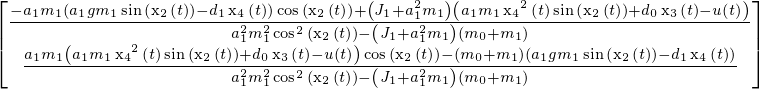

In [22]:
xu_subs = [(dq0_t, x3_t), (dq1_t, x4_t), (q0_t, x1_t), (q1_t, x2_t), (F, u_t)]
ddq = ddq.subs(xu_subs)
ddq = sp.simplify(ddq)
ddq

In [23]:
dx_t = sp.Matrix([x3_t, x4_t, ddq[0], ddq[1]])
ff = dx_t.subs([(u_t, 0)])
gg = dx_t.diff(u_t)

## 2.3 System Analysis
### 2.3.1 Equilibria
An equilibrium is a point in the state space, where the trajectory of the system dynamics is constant. To find such a point, $\dot{\mathbf{x}}$ is set equal to the zero vector. The result is a nonlinear equation system:
\begin{align}
\mathbf{0} = \mathbf{f}(\mathbf{x}) + \mathbf{g}(\mathbf{x})\mathbf{u}
\end{align}
The equation is dependent on the control vector $\mathbf{u}$. But for now, only the equlibria of the autonomous system $\mathbf{f}(\mathbf{x})$ are of interest, therefore we set $\mathbf{u}:= \mathbf{0}$.
To find the equilibria $\mathbf{x}_{0,i}(i = 1,2,...)$ of the autonoums system, the following nonlinear equation system has to be solved:
\begin{align}
\mathbf{0} = \mathbf{f}(\mathbf{x})
\end{align}

In [24]:
x0 = sp.solve(ff, x_t)
x0

The result are two equilbria $\mathbf{x}_{0,1}$ and $\mathbf{x}_{0,2}$ that are independent of the state variable $x_1$, the position of the cart. The two eqilibria are the pole in the upright and downright position at zero velocity of both cart and pole, as one would intuitively guess. But the equilibria of a system can not always be simply found by intuition, like in the cart-pole case, therefore the equilibria should always be found by the shown method.

### 2.3.2 Obtaining a linear state space model
To obtain a linear state space model, a taylor expansion of the nonlinear equation is used. 
\begin{align}
\dot{\mathbf{x}}-\dot{\mathbf{x}}_{0,i} &\approx \underbrace{\mathbf{f}(\mathbf{x}_{0,i}) +\mathbf{g}(\mathbf{x}_{0,i})\mathbf{u}_0}_{=0}
+ \underbrace{\frac{\partial}{\partial \mathbf{x}}\left(\mathbf{f}(\mathbf{x}) +\mathbf{g}(\mathbf{x})\mathbf{u}\right)\Big|_{\substack{\mathbf{u} = \mathbf{u}_0 \\\mathbf{x}=\mathbf{x}_{0,i}}}}_{=:A_i}(\mathbf{x}-\mathbf{x}_{0,i})
+ \underbrace{\frac{\partial}{\partial \mathbf{u}}\left(\mathbf{f}(\mathbf{x}) +\mathbf{g}(\mathbf{x})\mathbf{u}\right)\Big|_{\substack{\mathbf{u} = \mathbf{u}_0 \\\mathbf{x}=\mathbf{x}_{0,i}}}}_{=:B_i}(\mathbf{u}-\mathbf{u}_0)+\mathcal{O}(2)
\end{align}
First the linearization is done for the general case. Then, specific linear system matrices at the eqilibria are evaluated.

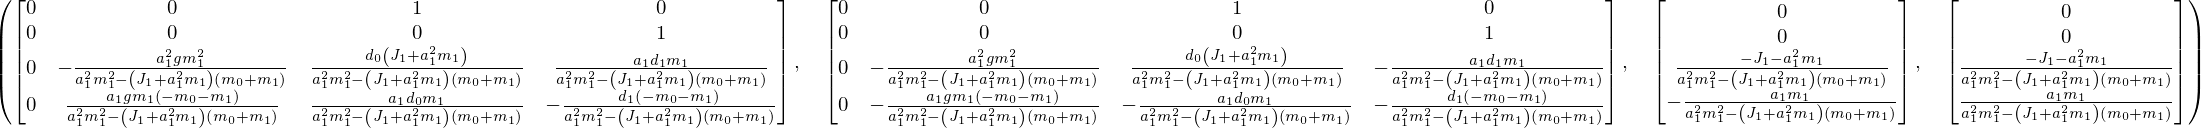

In [25]:
# separate ("unpack") equilibrium points
x01, x02 = x0

A = dx_t.jacobian(x_t)
B = dx_t.diff(u_t)

eql1_rplmts = list(zip(x_t, x01))
eql2_rplmts = list(zip(x_t, x02))


A1 = A.subs(eql1_rplmts) # pole upright
B1 = B.subs(eql1_rplmts) # pole upright
A2 = A.subs(eql2_rplmts) # pole downright
B2 = B.subs(eql2_rplmts) # pole upright
A1, A2, B1, B2

### 2.3.3 Controllability

A linear time-invariant (LTI) system 
\begin{align}
\dot{\mathbf{x}} = A \mathbf{x} + B \mathbf{u},
\end{align}
with 
\begin{align}
\mathbf{x} \in \mathbb{R}^n, \mathbf{u} \in \mathbb{R}^m  \quad A \in \mathbb{R}^{n \times n}, B \in \mathbb{R}^{n\times m}
\end{align}
is controlable if and only if the system states $\mathbf{x}$ can be changed by changing the system input $\mathbf{u}$.
To investigate the controllability of the system, we use the Kalman criterion of controllabilty, which says that a LTI system is controllable if the Kalman controllabilty matrix $Q_c$ is full rank.
\begin{align}
Q_c := \begin{pmatrix}B, AB,..., A^{n-1}B\end{pmatrix}
\end{align}
\begin{align}
\mathrm{rank} (Q_c) = n
\end{align}

### Concatenating column vectors to a matrix with SymPy
Given the to column vectors $a, b \in \mathbb{R}^n$, concatenating them to a matrix $(a,b)\in \mathbb{R}^{n\times2}$ is not trivial in SymPy. Have a look at the following example:

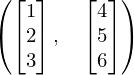

In [26]:
a = sp.Matrix([1, 2, 3])
b = sp.Matrix([4, 5, 6])
a, b

The resulting matrix should have two columns and three rows. But calling `sp.Matrix([a,b])` returns a column vector:

In [27]:
sp.Matrix([a,b])

Instead sympy provides `row_join`:

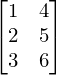

In [28]:
a.row_join(b)

---
With the shown method, the Kalman controllability matrix can be computed.

In [29]:
Q_c1 = B1.row_join(A1*B1).row_join(A1**2*B1).row_join(A1**3*B1)

To obtain a real valued matrix, the previously defined parameter values are substituted.

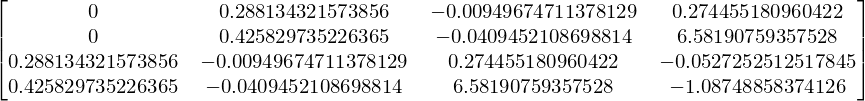

In [30]:
Q_c1 = Q_c1.subs(params_values)
Q_c1

Then the rank of $Q_{c,1}$ is computed:

In [31]:
Q_c1.rank(simplify=True)

**Note**: Calculating the rank of a numerical matrix can be tricky, due to the fact that the computer has to decide whether a small numerical value is equal to or different from zero.

For the (educated) user to be sure the best is to have a look at the singular values.

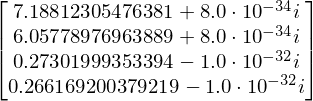

In [32]:
sp.Matrix(Q_c1.singular_values()).evalf()

The smallest singular value is $\approx 0.27 \gg 0$ which means the matrix is regular. The very small imaginary 
parts are result of numerical calculation and can be neglected.

---

$\mathrm{rank} (Q_{c,1}) = 4 = n$, the system is controllable in the upper equilibrium.

## 2.4 Linear Quadratic Regulator (LQR)

The linear quadratic regulator (LQR) is a linear control scheme often used in pracitcal applications. With this method, an optimal state feedback of the closed loop system can be designed. Instead of placing the poles of the closed loop system manually (i.e. by Ackermann's formula), a linear feedback control law $\mathbf{u}=-K\mathbf{x}$ can be derived, such that the cost function $J$ is minimized.

\begin{align}
J &= \int_{t_0=0}^\infty \mathbf{x}(t)^\textrm{T}Q\mathbf{x}(t)+\mathbf{u}(t)^\textrm{T}R\mathbf{u}(t) \mathrm{d}t \\
Q &\in \mathbb{R}^{n\times n}, R \in \mathbb{R}^{m\times m} - \textrm{ diagonal weight matrices}
\end{align}

$K=R^{-1}B^\textrm{T}P$, where $P$ is the solution to the continuous time algebraic Riccati equation (ARE):

\begin{align}
A^\textrm{T}P+PA-PBR^{-1}B^\textrm{T}P + Q = 0
\end{align}
$A, B$ are the system matrices.

The ARE can be solved in Python with the SciPy package:
At first, the weight matrices are choosen. A high value stands for high cost of the corresponding signal.

Note that if $Q \ge 0$ and $R > 0$ then the control law $\mathbf{u}=-K\mathbf{x}$ places the poles of the closed loop always in the open left half-plane.

In [33]:
Q = 10*np.eye(4)
R = 0.1
Q, R

(array([[ 10.,   0.,   0.,   0.],
        [  0.,  10.,   0.,   0.],
        [  0.,   0.,  10.,   0.],
        [  0.,   0.,   0.,  10.]]), 0.1)

The parameters are substituted into the system matrices of the upper equilibrium and the resulting matrices are converted to the correct type.

In [34]:
A = A1.subs(params_values)
B = B1.subs(params_values)
A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
A, B

(array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00],
        [  0.00000000e+00,   6.43606254e-01,  -2.88134322e-02,
          -2.80536630e-03],
        [  0.00000000e+00,   1.54492403e+01,  -4.25829735e-02,
          -6.73405174e-02]]), array([[ 0.        ],
        [ 0.        ],
        [ 0.28813432],
        [ 0.42582974]]))

The SciPy package is imported and the ARE is solved to obtain $P$.

In [35]:
import scipy as sci
from scipy import linalg

In [36]:
P = sci.linalg.solve_continuous_are(A, B, Q, R)
P

array([[  18.64638492,  -42.32305222,   12.38388353,  -10.72781326],
       [ -42.32305222,  343.63231708,  -68.00490028,   83.06410971],
       [  12.38388353,  -68.00490028,   18.74020643,  -17.0827318 ],
       [ -10.72781326,   83.06410971,  -17.0827318 ,   21.3363659 ]])

Finally the feedback matrix $K$ is computed.

In [37]:
K = 1/R*B.T.dot(P)
K

array([[ -10.        ,  157.76622042,  -18.74638492,   41.63537705]])

## Simulation

For the simulation SciPy's integrate package is used.

In [38]:
from scipy import integrate

At first, all relevant simulation parameters are defined.

In [39]:
t0 = 0 # start time
tf = 10 # final time
dt = 0.04 # stepsize
tt = np.arange(t0, tf, dt) # simulation time
x0 = np.array([1, 0.3, 0, 0]) # initial value
dx_t = dx_t.subs(params_values) # substitute the parameters in dx_t

The right hand side of $\dot x=f(x)$ has to be converted from a symbolic expression to a (fast) callable python function.

In [40]:
x1, x2, x3, x4, u = sp.symbols("x1, x2, x3, x4, u")
xx = [x1, x2, x3, x4]

dx_t_with_symbols = dx_t.subs(list(zip(x_t, xx))).subs(u_t, u) # replacing all symbolic functions with symbols

dx_func = sp.lambdify((x1, x2, x3, x4, u), dx_t_with_symbols, modules="numpy") # creating a callable python function

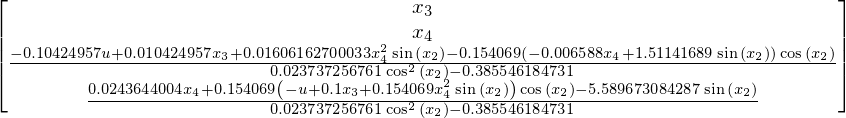

In [41]:
dx_t_with_symbols

In [42]:
# plausibility check1: equilibrium 1 (return value should be (0, 0, 0, 0))
dx_func(0, 0, 0, 0, 0)

array([[ 0.],
       [ 0.],
       [-0.],
       [-0.]])

In [43]:
# plausibility check1: equilibrium + initial force
dx_func(0, 0, 0, 0, 2)

array([[ 0.        ],
       [ 0.        ],
       [ 0.57626864],
       [ 0.85165947]])

---
A wrapper function is needed to evaluate the control algorithm and have the right argument-signature (t, x) for simulation.

The differential equation of the system is implemented in a function `fbODE(t, x)` (feedback ODE).

In [44]:
def fbODE(t, x):
    '''Nonlinear system of equations dx/dt = f(x,u) = f(x,-K*x) = f(x)'''
    u = -K.dot(x) # define the control law
    return dx_func(*x, u).T[0]

Finally the initial value problem is solved.

In [45]:
sol = sci.integrate.solve_ivp(fbODE, (t0, tf), x0, t_eval=tt)

In [46]:
xt = sol.y.T 

## Plotting the results

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [48]:
def cartPolePlot(xt):
    fig1, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig2, (ax3, ax4) = plt.subplots(2, 1, sharex=True)
    ax1.plot(tt, xt[:,0])
    ax2.plot(tt, xt[:,1])
    ax3.plot(tt, xt[:,2])
    ax4.plot(tt, xt[:,3])

    ax1.set(ylabel=r'$x_0$')
    ax2.set(ylabel=r'$\varphi_1$')
    ax3.set(ylabel=r'$\dot x_0$')
    ax4.set(ylabel=r'$\dot \varphi_1$')
    ax2.set(xlabel=r't in s')
    ax4.set(xlabel=r't in s')
    ax1.grid('on')
    ax2.grid('on')
    ax3.grid('on')
    ax4.grid('on')

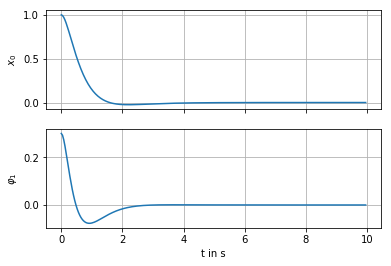

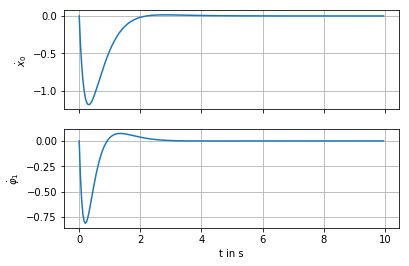

In [49]:
cartPolePlot(xt)

## Animating the results

In [50]:
from matplotlib import animation
from IPython.display import HTML
# equivalent to rcParams['animation.html'] = 'html5'
mpl.rc('animation', html='html5')
import matplotlib.patches as patches

In [51]:
def cartPoleAnimation(xt):
    # mapping from theta and s to the x,y-plane (definition of the line points, that represent the pole)
    def cart_pole_plot(l, xt):
        x_pole_end = -l * np.sin(xt[:, 1]) + xt[:, 0]
        x_cart = xt[:, 0]
        y_pole_end = l * np.cos(xt[:, 1])
        return x_pole_end, y_pole_end, x_cart

    # line and text
    def animate(t):
        thisx = [x_cart[t], x_pole_end[t]]
        thisy = [0, y_pole_end[t]]
    
        pole.set_data(thisx, thisy)
        cart.set_xy([x_cart[t]-0.1, -0.05])
        time_text.set_text(time_template%(t*dt))
        return pole, cart, time_text,
    
    [x_pole_end, y_pole_end, x_cart] = cart_pole_plot(0.5, xt)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel=r'$x_1$')
    plt.ylim((-0.1, 0.6))
    plt.title('Cart-Pole LQR')
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 1.2, '', transform=ax.transAxes)
    rail, = ax.plot([min(-1, 1.2*min(x_cart)), max(1, 1.2*max(x_cart))], [0,0], 'ks-', zorder=0)
    pole, = ax.plot([], [], 'b-', zorder=1, lw=3)
    cart = patches.Rectangle((-0.1, -0.05), 0.2, 0.1, fc='b', zorder=1)
    ax.add_artist(cart)
    # animation using matplotlibs animation library
    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(xt)), interval=dt*1000, 
                          blit=True)
    return ani

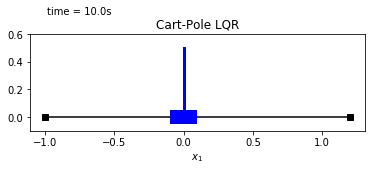

In [52]:
cartPoleAnimation(xt)

An animation can sometimes be a helpful tool to check, wether the model equations are implemented correctly. A strange behaviour is much easier to detect in a visual animation, compared to looking at the plotted state trajectories.

## Feedforward control
The designed feedback controller successfully stabilizes the system in the unstable equilibrium $(0, 0, 0, 0)^\textrm{T}$. To stabilize the cart at another $x_0$-position, it is necessary to design a feedforward control. 

Recapture the linearized feedback control system dynamics:
\begin{align}
\dot x(t) &= (A -BK)x(t) \\
y(t) &= Cx(t)
\end{align}
A feedforward input $u_{ff}$ is introduced:
\begin{align}
\dot x(t) &= (A -BK)x(t) + B u_{ff}(t) \\
y(t) &= Cx(t)
\end{align}
with
\begin{align}
u_{ff}(t) = - V y_d
\end{align}
where $V$ is a feedforward filter and $y_d$ is the stationary desired system output.

This leads to new dynamics:
\begin{align}
\dot x(t) &= (A -BK)x(t) - B V y_d \\
y(t) &= Cx(t)
\end{align}

The Laplace transform of this new system is given by:
\begin{align}
sX(s) &= (A -BK)X(s) - B V Y_d \\
Y(s) &= CX(s)
\end{align}

Now it is easy to solve for $X(s)$
\begin{align}
&& sX(s) &= (A -BK)X(s) - B V Y_d \\
\Leftrightarrow \quad &&(sI - A +BK)X(s) &= - B V Y_d \\
\Leftrightarrow \quad &&X(s) &= - (sI - A +BK)^{-1}(B V Y_d) \\
\end{align}

Substituting the equation for $X(s)$ in the output equation of the system results in:
\begin{align}
Y(s) &= - C(sI - A +BK)^{-1}(B V Y_d)
\end{align}

---
If $t$ goes to infinity, the system output $y$ should be equal to the desired system output $y_d$:
$$\lim_{t\to\infty}y(t) \overset{!}{=} y_d$$

In the s-Domain this corresponds to:
$$\lim_{s\to0}Y(s) \overset{!}{=} Y_d$$
(An intuition: If $s=0$, the derivatives are equal to zero, which means the system is in steady state)

$$Y(0)=Y_d = - C(- A +BK)^{-1}(B V Y_d)$$

Solving for V results in:
$$V = [C(A - BK)^{-1}B]^{-1}$$ 

By setting $C$, the output is defined as $y=x_0$ (position of the cart).

In [53]:
C = np.array([1, 0, 0, 0])

Finally the feedforward filter $V$ is computed:

In [56]:
V = ((C.dot(np.linalg.inv((A-B.dot(K))))).dot(B))**(-1)
V

array([10.])

The function of the control system (feedback and feedforward control) is defined:

In [57]:
def ffODE(t, x, yd):
    '''Nonlinear system of equations dx/dt = f(x,u) = f(x,-K*x) = f(x)'''
    u = -K.dot(x) - V*yd # define the control law (feedback / feedforward)
    return dx_func(*x, u).T[0]

In [58]:
sol = sci.integrate.solve_ivp(lambda t, x: ffODE(t, x, yd=2), (t0, tf), x0, t_eval=tt)

In [59]:
xt = sol.y.T

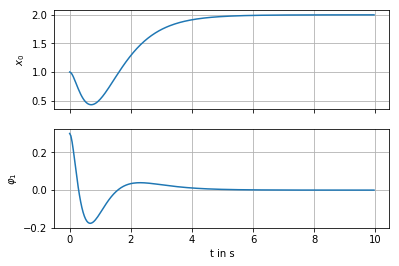

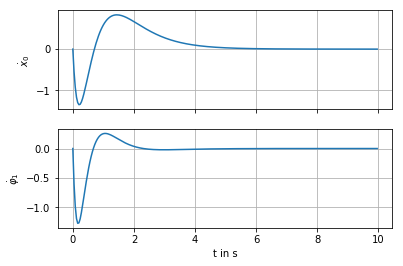

In [60]:
cartPolePlot(xt)

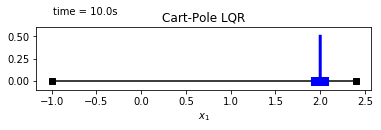

In [61]:
cartPoleAnimation(xt)

# C-Code export

Work in Progress